### Evolution Strategies

In [2]:
import numpy as np
from numpy import sin, cos, pi, e 
import math
import matplotlib.pyplot as plt 

In [3]:
def evaluate(fitness_func, candidate, batch=False, noisy=False):
    if batch:
        return np.array([fitness_func(candidate, noisy=noisy) for w in batch])
    else:
        return fitness_func(candidate, noisy=noisy)

def evolve(dim, 
           fitness_func, 
           n_samples=100, 
           n_iterations=50, 
           lr_mean=0.5, 
           lr_logstd=0.5, 
           initial_mean=None, 
           initial_std=None, 
           plot=False): 
        
    # Initial mean
    if initial_mean is not None:
        assert len(initial_mean) == dim, \
            f"initial_mean has the wrong number of dimensions. Expected {dim}, but got {len(initial_mean)}"
        search_mean = initial_mean
    else:
        search_mean = np.zeros(dim)
    
    # Initial standard deviation 
    if initial_std is not None:
        assert len(initial_std) == dim, \
            f"initial_std has the wrong number of dimensions. Expected {dim}, but got {len(initial_std)}"
        search_logstd = np.log(initial_std) 
    else:
        search_logstd = np.log(np.ones(dim)) 
    
    f = np.empty(n_samples)  # fitness scores 
    unnorm_f = f 
    
    loggrad_mean   = np.empty((n_samples, dim))
    loggrad_logstd = np.empty((n_samples, dim))
    
    solution_history     = [search_mean.copy()]
    fitness_mean_history = [None]
    fitness_max_history  = [None]
    
    # Run evolution
    for g in range(n_iterations):
        search_std = np.exp(search_logstd)
        # Sample and evaluate offspring 
        offspring = []
        i = 0
        for _ in range(n_samples//2):
            # Mirror sampling:
            noise = np.random.randn(dim)
            for j in [-1, 1]:
                # Sample 
                y = search_mean + search_std * j * noise 
                offspring.append(y)
                # Evaluate 
                f[i] = evaluate(fitness_func, y) 
                # Log-gradients of search parameters 
                loggrad_mean[i]   = (y-search_mean)/np.multiply(search_std, search_std)
                loggrad_logstd[i] = np.multiply(y-search_mean, y-search_mean)/np.multiply(search_std, search_std)-1
                i += 1
        
        # Normalize fitness scores
        unnorm_f = f
        f = (f-np.mean(f))/(np.std(f)+1e-8)
        
        # Gradients of expected fitness
        grad_J_mean   = (f[:, None] * loggrad_mean  ).mean(axis=0)
        grad_J_logstd = (f[:, None] * loggrad_logstd).mean(axis=0)
        
        # Fisher matrices
        fisher_mean   = np.diag((loggrad_mean ** 2).mean(axis=0))
        fisher_logstd = np.diag((loggrad_logstd ** 2).mean(axis=0))
        
        # Update search parameters 
        search_mean   += lr_mean   * (np.linalg.inv(fisher_mean)   @ grad_J_mean)
        search_logstd += lr_logstd * (np.linalg.inv(fisher_logstd) @ grad_J_logstd)
        
        std = np.exp(search_logstd) 

        # Current best solution
        solution = offspring[f.argmax()] 
        
        # Track history 
        solution_history.append(solution)
        fitness_mean_history.append(unnorm_f.mean())
        fitness_max_history.append(unnorm_f.max())

    if plot:
        plt.ylabel("Fitness")
        plt.xlabel("Generation")
        plt.plot(fitness_max_history, label="max")
        plt.plot(fitness_mean_history, label="mean")
        plt.legend()
    
    # return solution, solution_history, fitness_mean_history, fitness_max_history
    return solution, solution_history

---

**Having some fun with optimization (including non-differentiable, black-box):**

y_true: [3. 3.]
y_pred: [2.99541714 3.01000052]


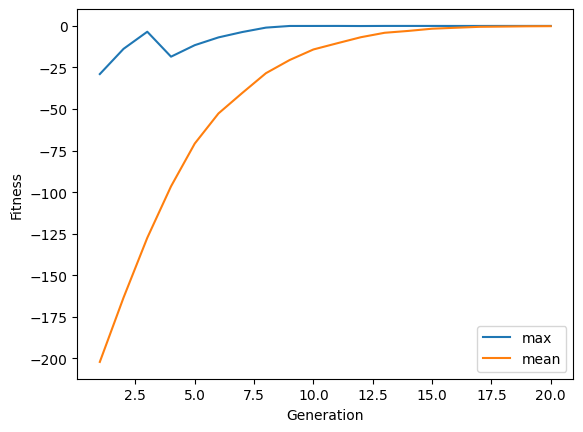

In [4]:
# Example 1

# Find optimal solution to this multidimensional parabola in 2D

y_true = np.array([3.0, 3.0])

def fitness_func1(y, noisy=False):
    y1 = y[0]-y_true[0]
    y2 = y[1]-y_true[1]
    f = -10*((y1)**2 + (y2)**2) 
    
    noise = 1.0 * np.random.randn() if noisy else 0.0
    return f + noise

solution, _ = evolve(
    dim=2, 
    fitness_func=fitness_func1, 
    n_iterations=20, 
    plot=True
)

print("y_true:", y_true)
print("y_pred:", solution)

y_true: [0 1 0 1 0 1 0 0 0 0]
y_pred: [0 1 0 1 0 1 0 0 0 0]


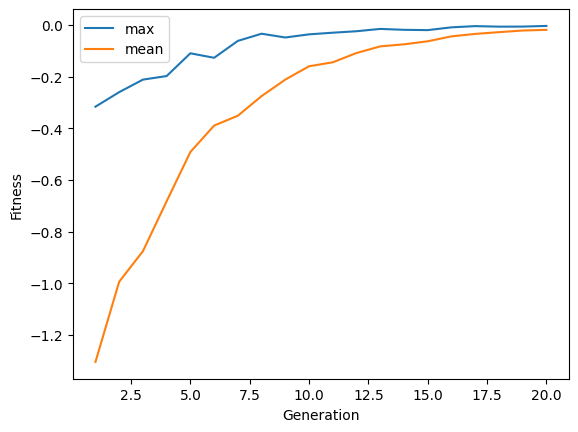

In [5]:
# Example 2

# Generate a random "true" bitstring
# Evolve a vector with the same number of dimension as the number of bits in the target bitstring
# Then to turn the vector into a solution bitstring, just clip to the interval [0, 1] and then round 
# to the nearest integer

y_true = np.random.randint(0, 2, 10)  # a single 10-bit true string
print("y_true:", y_true)

def fitness_func2(y, noisy=False):    
    # squared error between y and y_true 
    f = -((y_true-y)**2).mean()  
    noise = 0.1 * np.random.randn() if noisy else 0.0
    return f + noise

solution, _ = evolve(
    dim=10, 
    fitness_func=fitness_func2, 
    n_iterations=20, 
    plot=True
)

print("y_pred:", solution.clip(0, 1).round().astype(int))

y_true: Hello there, my friend! How is it going?
y_pred: Hello there, my friend! How is it going?


['aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa',
 "caGceZWjaa'icUa,iriKkdkcicgPqaNcePaayvmt",
 'HqAOjKgfsdLWiRCZYewclJeeCqaaaqAicj!XjHHq',
 'riHUbAMrGSGqLLSzsqa�OyyoyvBGimeeysocKeai',
 "LaUaMriaageWbf'!mqaSaklWUairKObGrataHqtJ",
 'mfypuuodayreUseY?himScuiHAqsubfGOHctHfIM',
 'BaiadBAiGrHiWeeqfyWgqv?rGKlgacaadaofJegk',
 "OvaafGHheacGWcmTvIBnQQ'GcJeiWuqk fcRabNa",
 "'yiGIjmquaNGseAUbvKmOqmdNkg�iuiIeyGHHLdJ",
 'OfjIUiqvgfqGnfs�MdbdfqqaeSc!qrbOZTuDiTef',
 "Hssgi�UIaetcSbaKGacqAHKI aEXaq'n kIenfAs",
 'uzfPWrGwabKujKurKlrDteqA�IqdqhjOcJiAQkRc',
 'jcbfozenbYWeZdgisbGGPcq W�vrqaKjuPcOicdx',
 'qmicAVaetb,VcbGuddPuSp zWaq�bfOaaqaeliOe',
 'GiIbGCTcuL,aOgi tCHambJeqdc?kP�Gkdb�iwCc',
 " acKCaMOePcsXymn?HSHGIhaT'cHOAJItP�nibhw",
 "GmAkbPhLaqqaWceLXrkeNcf!ImejiIXati�'if,K",
 "GejfiRvcEWbe'OGbfiivdI!ZHeuPGWRObideGif�",
 'awJaaWahey,aboO�uvmwDqqR!cMuicXabH,qiheD',
 'Cipby WNfGuePejWbrSynaryKgkCkzdisak�mjcs',
 'WamlQCIhL,CuicPv!acvnlb NKcyeaWirlsa GAw',
 "fyjie�ZnmqeKrqTJMBjbed�'Gca!eaziuPVebaAs",
 "GCOfeXzJ

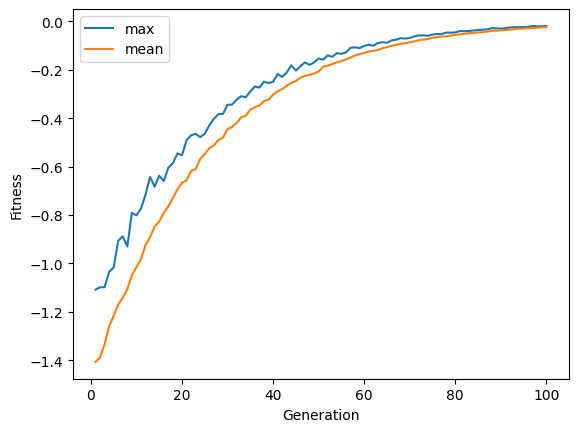

In [6]:
# Example 3

# Take some string message, map each character to a bitstring, e.g. "a" -> "00000", "b" -> "00001", etc.
# So that the string message is one long bitstring, e.g. "ba" -> "0000100000"
# Then evolve a bitstring that reconstructs this bitstring using squared error between predicted and true values
# (this happens in continuous space! not discrete space)
# Then decode the reconstructed bitstring back into the string message 

alphabet = "abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ,!?.' " 
n_bits = int(np.log2(len(alphabet))+0.5)  # max num bits needed to encode a character in alphabet

def encode_char(char):
    index = alphabet.find(char)
    binary = bin(index)[2:]
    padding = "0" * (n_bits-len(binary))
    return padding + binary 

def encode_message(message):
    message = "".join(encode_char(char) for char in message if char in alphabet)
    return message

def decode_message(code):
    assert len(code) % n_bits == 0, \
        f"Corrupted or incorrect message (Wrong number of bits, {len(code)}). Message cannot be decoded."
    message = ""
    for i in range(0, len(code), n_bits):
        char_code = code[i:i+n_bits]
        char_index = int(char_code, 2)
        if char_index < len(alphabet):
            message += alphabet[char_index]
        else:
            message += "�"
    return message

def vector_to_bitstring(y):
    # e.g. y = np.array([0.3842, 0.4623, 0.9450, 1.2004]) 
    # We want to turn this into bitstring "0011" 
    return "".join(y.clip(0, 1).round().astype(int).astype(str))


y_true = "Hello there, my friend! How is it going?"
print("y_true:", y_true)
n_message_bits = len(y_true) * n_bits
y_true_vector = np.array(list(encode_message(y_true))).astype(int)

def fitness_func3(y, noisy=False): 
    f = -((y_true_vector-y)**2).mean()  
    noise = 0.1 * np.random.randn() if noisy else 0.0
    return f + noise

# solution = evolve(n_message_bits, fitness_func3, n_iterations=10, plot=True)
solution, solution_history = evolve(
    dim=n_message_bits, 
    fitness_func=fitness_func3, 
    n_iterations=100, 
    plot=True
)

print("y_pred:", decode_message(vector_to_bitstring(solution)))
[decode_message(vector_to_bitstring(solution)) for solution in solution_history]

In [7]:
# Example 4

# Let's do something where we don't already know the correct answer 
# Find a string (represented like above, using bits) such that if you pass it through a pseudo-hash, the hash 
# is as close as possible to some target

target_hash = 10*"0" + 17*"1"

def pseudo_hash(s: str, mod=10**8):
    primes = [
        2, 3, 5, 7, 11, 13, 17, 19,
        23, 29, 31, 37, 41, 43, 47, 53,
        59, 61, 67, 71, 73, 79, 83, 89,
        97, 101, 103, 107, 109, 113, 127, 131
    ]
    total = 0
    for i, c in enumerate(s):
        # Soft sinusoidal kernel with growth
        weight = int(100 * (1 + math.sin(i * 0.5)))
        total += ord(c) * weight
    """
    bin_hash = bin(total % mod)[2:]
    n_digits = len(bin(mod)[2:])
    padding = (n_digits-len(bin_hash))*"0"
    padded_bin_hash = padding + bin_hash
    return padded_bin_hash 
    """
    return total % mod 

"""
def fitness_func4(y, noisy=False):    
    # 
    #
    #
    f = ...
    #
    #
    #
    noise = 0.1 * np.random.randn() if noisy else 0.0
    return f + noise
"""

mod = 10**8
dim = len(bin(mod)[2:])

"""
solution, _ = evolve(
    dim=dim, 
    fitness_func=fitness_func4, 
    n_iterations=100, 
    plot=True
)
""";

pseudo_hash("hello")

87701